# Classification - Multilayer Perception

Multilayer perceptrons (MLP) are one of the simplest neural networks that can be applied to a problem. They use only the core building blocks of neural networks: simple neurons.

This notebook outlines how to setup a simple MLP (also known as fully-connected networks) and apply it to the MNIST dataset which is series of handwritten digits from zero to nine.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mj-will/intro2ml/blob/master/notebooks/classification-MLP.ipynb)

## Imports

[Keras](https://keras.io/) is now part of [Tensorflow](https://www.tensorflow.org) and all imports with include tensorflow. There are lots of examples of how to use different elements of Keras on its [tensorflow page](https://www.tensorflow.org/guide/keras)

Below are the imports that are needed for this example, each will be explained when used, so don't worry about them right now.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.2)

import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Dataset

Neural networks rely on data to learn and in this example we'll be looking at the MNIST dataset.

MNIST is a handwritten digit database with a training set of 60,000 examples and a test set of 10,000 examples. The images are all 28x28 and greyscale. The testing data will be used to validate the network's peformance once it has been trained.

It is available [here](http://yann.lecun.com/exdb/mnist/), but is included in Keras and will automatically download.

In [2]:
# load data using the imp
(x_train, y_train), (x_test, y_test) = mnist.load_data()

It's common practice to refer to the input data as "x" and the output as "y" as we'll be following that convention here.

Let's have a look at some of the data.

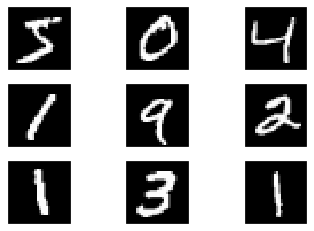

In [3]:
fig, axs = plt.subplots(3,3)
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].imshow(x_train[i].reshape(28,28), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

Here, the 'x' arrays are the images and the 'y' arrays are the labels

### General parameters

We need to define some general parameters for networks we're going to use:
* Batchsize: refers to the number of images/samples passed to the network in a single instance of training
* Number of classes: refers to the number of possible classes in the data, in this case 10 since there a 10 different digits (0-9)
* Epochs: refers to the number of times the network will train on the complete dataset

In [4]:
batch_size = 128    # number of images passed each iteration of training
num_classes = 10    # digits 0 to 9, so 10 classes
max_epochs = 20     # number of full passes of the dataset

## MLP

This example uses a simple deep neural net (more than 1 layer)

For an MLP the data needs to be parsed as 1D array, rather than a 2D image. 

So, the data is reshaped according to the number of samples (60,000 or 10,000) and the size of the image 784 (28x28).

The data is then normalized from $[0,255]$ to $[0,1]$ since neural networks will learn quicker if the data is normalised. This is not to say it's impossible to train a network without normalised data.

In [5]:
# reshape data
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# normalize data
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'training samples')
print(x_test.shape[0], 'test samples')

60000 training samples
10000 test samples


As is the content of the labels vectors looks something like this:
```
array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)
```
The NN expects them labels as binary class matrix instead, i.e. a matrix with a 1 in the position that corresponds to the given class. This is clearer with an example.

In [6]:
# convert class vectors to binary class matrices
# use built-in keras utilties to do this
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Now the label for each image looks like this:
```
array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)
```
Notice that in the previous array the first digit was a 7. In the array that now corresponds to this values the 8th position is 1, corresponding to the class "7" since we're including 0.

### The Model

We now need to construct the neural network that we're going to training to classify the digits.

We start by defining the type of keras model. In this case we're using ```Sequential```. When using this type of model any layers we add are assumed to directly follow from the previous one. The other type is ```Model``` which you can read about [here](https://keras.io/models/model/).

We then add the input layer. In this case we're going to use a ```Dense``` layer, i.e. a simple fully connected layer. We need to specify the number of neurons (or nodes), the [activation function](https://en.wikipedia.org/wiki/Activation_function) and the shape of the input with keyword argument ```input_shape```.

We then add another dense layer but this time we don't need to specify the input shape.

Finally we the output layer. Since this is a classifcation task we want the network to predict one of the ten classes, so we use ten neurons. As for the activation function, we use a [softmax function](https://en.wikipedia.org/wiki/Softmax_function) since this ensures the sum of all the output is one, so they can be thought of as a sort of probability.

In [7]:
model = Sequential()    # define the type of keras model
# add first layer with relu activation
model.add(Dense(64, activation='relu', input_shape=(784,)))
# add another layer
model.add(Dense(64, activation='relu'))
# add the output layer with softmax actiavtion for classication
model.add(Dense(num_classes, activation='softmax'))
# print a summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


The model then needs to be compiled. It's at this stage that we specify the loss function, optimiser and metrics.

#### Loss function

As mentioned in the post there is one main loss function for multi-class problems: **categorical cross-entropy**

#### Optimiser

The optimiser is the algorithm that will explore the parameter space of the network's weights and update them accordingly. In this case we're going to use [**Adam**](https://arxiv.org/abs/1412.6980) which is widely used and incorporates adaptive learning rates.

Each optimiser will have hyperparameters that can be tweaked such as the learning rate, we will leave as their default values for this problem.

#### Metrics

Metrics are additional quantaties that can be used to quantify performance. In this case we can use **accuracy** which will be a percentage.

In [8]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

## The Training

We're now ready to train the network. The `model` class has a method called `fit` that trains the model given some inputs. This is simplest way to train a model but has some limitations, for example when dealing with very large datasets that can't be loaded into memory.

In [9]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3833 - accuracy: 0.8908 - val_loss: 0.1928 - val_accuracy: 0.9439
Epoch 2/20
60000/60000 [==============================] - 7s 113us/sample - loss: 0.1698 - accuracy: 0.9508 - val_loss: 0.1536 - val_accuracy: 0.9560
Epoch 3/20
60000/60000 [==============================] - 8s 140us/sample - loss: 0.1257 - accuracy: 0.9635 - val_loss: 0.1229 - val_accuracy: 0.9617
Epoch 4/20
60000/60000 [==============================] - 7s 110us/sample - loss: 0.1018 - accuracy: 0.9692 - val_loss: 0.1065 - val_accuracy: 0.9683
Epoch 5/20
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0834 - accuracy: 0.9753 - val_loss: 0.0954 - val_accuracy: 0.9711
Epoch 6/20
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0717 - accuracy: 0.9791 - val_loss: 0.0935 - val_accuracy: 0.9721
Epoch 7/20
60000/60000 [===========================

## Evaluation

Now the model is trained we can evaluate it's performance using the test set

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10023200724238158
Test accuracy: 0.9754


### Loss function

As mentioned before the optimisation process is a minimisation problem. The value of the loss function will refect this and we can plot it.

We can use the `history` object returned by `fit` which contains a python dictionary with the loss and metrics.

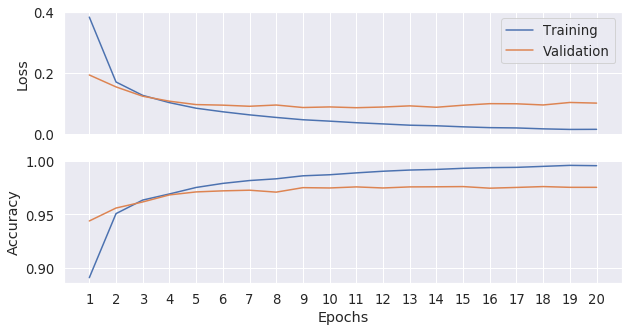

In [11]:
epochs = np.arange(1, max_epochs + 1, 1)
fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=True)
axs = axs.ravel()
axs[0].plot(epochs, history.history["loss"], label='Training')
axs[0].plot(epochs, history.history["val_loss"], label='Validation')
axs[1].plot(epochs, history.history["accuracy"], label='Training')
axs[1].plot(epochs, history.history["val_accuracy"], label='Validation')

axs[1].set_xticks(epochs)
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epochs")

axs[0].legend()
plt.show()

### Confusion matrix

In a multi-class classification problem a confusion matrix is useful way to understand how the neural network performs for each class.

We'll be using [Sklearn](https://scikit-learn.org/stable/) to compute the values and [Seaborn](https://seaborn.pydata.org/) for plotting.

In [12]:
from sklearn.metrics import confusion_matrix

#### Predictions
We need the preditctions for the test set and, importantly, we need to determine which class the network has predicted.

In [13]:
y_pred = model.predict(x_test)
print(f'Example of predicted values: \n {y_pred[0]}')
print(f'Corresponding true value: \n {y_test[0]}')

Example of predicted values: 
 [2.8019012e-10 1.8402149e-10 5.4224955e-07 5.5735923e-06 4.0304804e-12
 6.2704061e-12 1.6973253e-16 9.9999368e-01 1.3122440e-07 4.1502606e-08]
Corresponding true value: 
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


The sklearn function expects class labels rather than one-hot encoding. It's easy to convert back with `numpy.argmax` along the last axis

In [14]:
pred_class = np.argmax(y_pred, axis=1)
true_class = np.argmax(y_test, axis=1)

In [15]:
cm = confusion_matrix(true_class, pred_class)

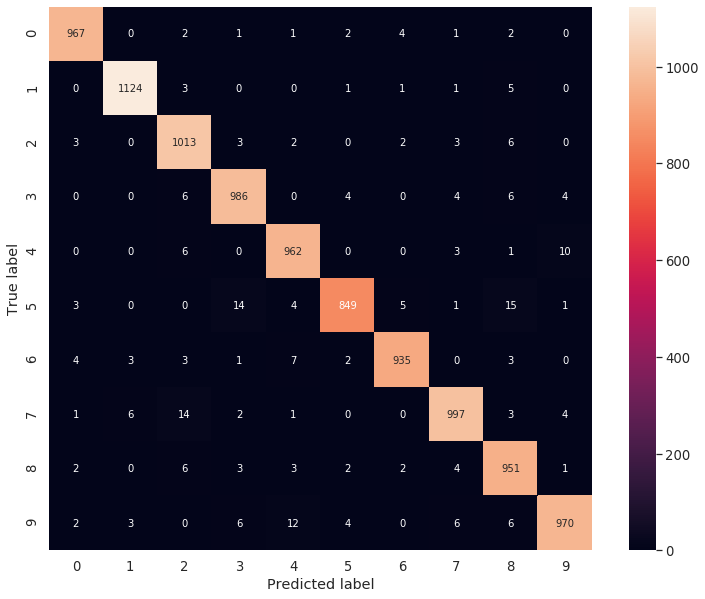

In [16]:
fig = plt.figure(figsize=(13, 10))
sns.heatmap(cm, annot=True, square=True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()